In [ ]:
import os
import pickle
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.sac import sac
from rlib.common.buffer import ReplayBuffer, RolloutBuffer
from rlib.common.evaluation import get_trajectory, save_frames_as_gif, validation
from rlib.common.logger import TensorBoardLogger
from rlib.common.policies import DeterministicMlpPolicy, MlpQCritic, StochasticMlpPolicy

%load_ext autoreload
%autoreload 2

In [120]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [121]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


## GCL

### Expert

In [17]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [18]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=20_000,
)

In [19]:
validation(env, actor)

-169.38176753538576

In [21]:
with open("./models/pendulum_stoc_expert", "wb") as file:
    pickle.dump(actor, file)

In [8]:
with open("./models/pendulum_stoc_expert", "rb") as file:
    expert_actor = pickle.load(file)

In [9]:
validation(env, expert_actor)

-136.4668935540488

In [113]:
rb = RolloutBuffer()

In [114]:
rb.collect_rollouts(env, expert_actor, trajectories_n=30)

In [115]:
expert_trajectories = rb.get_data()

### Train

In [116]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [117]:
class CustomNNRewardWrapper(gym.Wrapper):
    def __init__(self, env, reward_fn):
        super().__init__(env)
        self.reward_fn = reward_fn

    def step(self, action):
        """
        Args:
            action: (np.ndarray): (action_dim,)
        """
        observation, reward, terminated, truncated, info = self.env.step(action)

        observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
        action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

        reward_t = self.reward_fn(observation_t, action_t)
        reward = reward_t.item()

        return observation, reward, terminated, truncated, info


In [118]:
def gcl_loss(
    reward_net,
    learning_trajectories,
    expert_trajectories,
):
    loss = {}

    learning_observations = learning_trajectories["observations"]
    learning_actions = learning_trajectories["actions"]

    learning_rewards = reward_net(learning_observations, learning_actions).sum()

    expert_observations = expert_trajectories["observations"]
    expert_actions = expert_trajectories["actions"]

    expert_rewards = reward_net(expert_observations, expert_actions).sum()

    loss["reward"] = -(expert_rewards - learning_rewards)

    return loss

In [128]:
def gcl(
    env: gym.Env,
    expert_trajectories: dict[str, torch.Tensor],
    learning_actor: DeterministicMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    reward_net: RewardNet,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    reward_optimizer: Adam,
    total_episodes: int = 30,
):
    rollout_buffer = RolloutBuffer()
    env = CustomNNRewardWrapper(env, reward_net)

    logger = TensorBoardLogger(log_dir="./tb_logs/gcl_")

    for episode_n in range(total_episodes):

        rollout_buffer.collect_rollouts(env, learning_actor, trajectories_n=30)
        learning_trajectories = rollout_buffer.get_data()

        loss = gcl_loss(reward_net, learning_trajectories, expert_trajectories)

        loss["reward"].backward()
        reward_optimizer.step()
        reward_optimizer.zero_grad()

        env = CustomNNRewardWrapper(env, reward_net)

        sac(
            env,
            actor,
            critic_1,
            critic_2,
            actor_optimizer,
            critic_1_optimizer,
            critic_2_optimizer,
            total_timesteps=1000,
        )

        # Logging
        logger.log_scalars(loss, episode_n)

In [129]:
learning_actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

reward_net = RewardNet(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

reward_optimizer = Adam(reward_net.parameters(), lr=1e-4)

In [130]:
gcl(
    env,
    expert_trajectories,
    learning_actor,
    critic_1,
    critic_2,
    reward_net,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    reward_optimizer,
)

In [131]:
with open("./models/pendulum_nn_reward", "wb") as file:
    pickle.dump(reward_net, file)

### Visualisation

In [135]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [136]:
def original_reward(state, action):
    theta, theta_dot = state
    cost = theta**2 + 0.1 * theta_dot**2 + 0.001 * action**2
    return -cost

In [137]:
def nn_reward(state, action):
    theta, thetadot = state
    observation = np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
    action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

    reward_t = reward_net(observation_t, action_t)
    reward = reward_t.item()

    return reward

In [164]:
def plot_rewards(reward_fn):

    fig, axs = plt.subplots(ncols=3)

    theta_ls = np.linspace(-np.pi, np.pi)
    theta_dot_ls = np.linspace(-1, 1)
    action_ls = np.linspace(-1, 1)

    state = np.array([0, 0], dtype=np.float32)
    action = np.array(0)

    rewards = []
    for theta in theta_ls:
        state[0] = theta
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[0].plot(theta_ls, rewards)

    rewards = []
    for theta_dot in theta_dot_ls:
        state[1] = theta_dot
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[1].plot(theta_dot_ls, rewards)

    rewards = []
    for action in action_ls:
        reward = reward_fn(state, action)
        rewards.append(reward)

    axs[2].plot(action_ls, rewards)

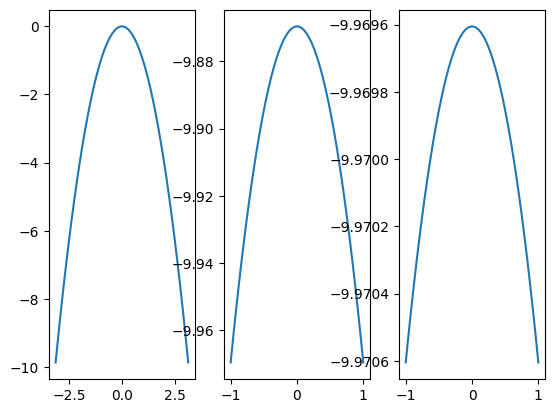

In [165]:
plot_rewards(original_reward)

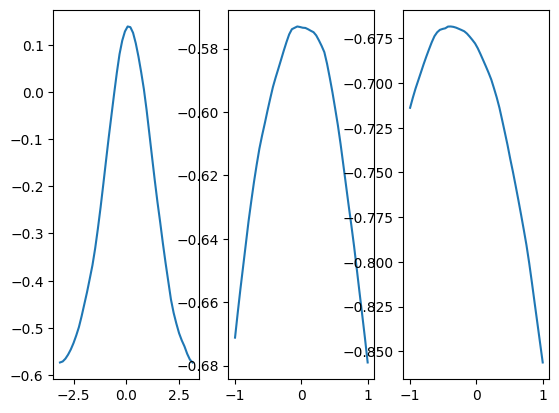

In [176]:
plot_rewards(nn_reward)

### Learning agent from learned reward

In [184]:
with open("./models/pendulum_nn_reward", "rb") as file:
    reward_net = pickle.load(file)

In [185]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [186]:
env = CustomNNRewardWrapper(env, reward_net)

In [187]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [181]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    total_timesteps=20_000,
)

In [188]:
validation(env, actor, deterministic=True)

-328.5924241580069

MovieWriter imagemagick unavailable; using Pillow instead.


saving...


{'states': [array([ 0.05717959,  0.9983639 , -0.31364465], dtype=float32),
  array([0.02045296, 0.9997908 , 0.7351283 ], dtype=float32),
  array([-0.06443454,  0.99792194,  1.6986718 ], dtype=float32),
  array([-0.18212599,  0.9832752 ,  2.373379  ], dtype=float32),
  array([-0.3463617 ,  0.93810105,  3.4108355 ], dtype=float32),
  array([-0.53509045,  0.84479475,  4.2184978 ], dtype=float32),
  array([-0.7194373 ,  0.69455737,  4.767541  ], dtype=float32),
  array([-0.87307525,  0.48758546,  5.1696486 ], dtype=float32),
  array([-0.9764281 ,  0.21584307,  5.8353376 ], dtype=float32),
  array([-0.9956562 , -0.09310634,  6.215931  ], dtype=float32),
  array([-0.91489583, -0.40368995,  6.446101  ], dtype=float32),
  array([-0.749551 , -0.6619466,  6.1573277], dtype=float32),
  array([-0.52266186, -0.8525401 ,  5.948265  ], dtype=float32),
  array([-0.29506853, -0.9554761 ,  5.00886   ], dtype=float32),
  array([-0.09880487, -0.9951068 ,  4.011218  ], dtype=float32),
  array([ 0.06177752,

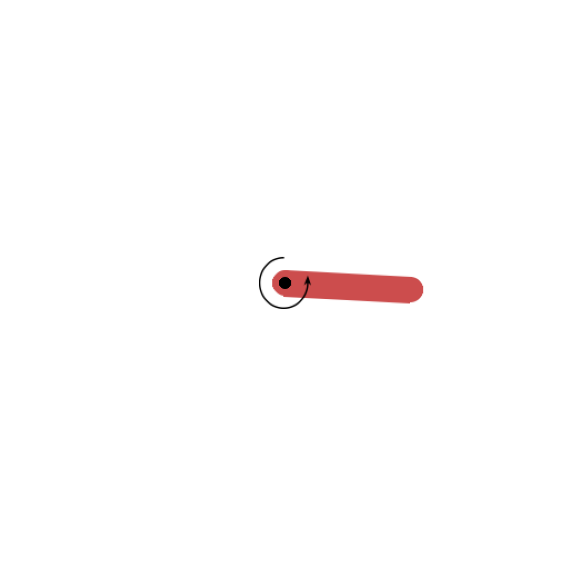

In [189]:
get_trajectory(env, actor, visualize=True)

## db

In [96]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [97]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


In [98]:
env.reset()

action = np.array([1]).reshape((action_dim,))
env.step(action)

(array([ 0.8564583 ,  0.5162162 , -0.13741326], dtype=float32),
 -0.3744487546671795,
 False,
 False,
 {})

In [99]:
reward_net = RewardNet(obs_dim, action_dim)
env = CustomNNRewardWrapper(env, reward_net)

In [106]:
env.reset()

action = np.array([1]).reshape((action_dim,))
env.step(action)

(array([-0.6536499 ,  0.7567971 ,  0.65377426], dtype=float32),
 -0.028410837054252625,
 False,
 False,
 {})

In [26]:
rb = RolloutBuffer()
actor = StochasticMlpPolicy(obs_dim, action_dim)

In [29]:
rb.collect_rollouts(env, actor, rollout_size=20)

In [31]:
data = rb.get_data()

In [32]:
print(
    data["observations"].shape,
    data["actions"].shape,
)

torch.Size([20, 3]) torch.Size([20, 1])


In [35]:
obs, _ = env.reset()

actions = []
for _ in range(10):
    action, _ = actor.predict(obs)
    print(action.shape)
    actions.append(action)
    next_obs, reward, term, trunc, _ = env.step(action)

(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


In [38]:
actions = torch.tensor(actions)

In [40]:
actions.shape

torch.Size([10, 1])